# Experiment 2

## Goals

* Experiment with a RNN for beat onset detection

This is a little far away from the larger goal of algorithmic generation, but an important building block. So far we've created a little bit of manual tagging process, where we build beat-annotated datasets manually. That's fine and all, but if we could get reliable beat detection we'd be in a better place and could automate this front-end process.

## Context

The two peices of established work in this domain are (Bock & Schedl)'s work and (Eyben et. al.). Both of these papers use LSTM networks to perform detection. Eyben's work targets the generalized problem of onset detection, while Bock's work is specific to beat tracking.

* Both achieved roughly state-of-the-art results using standardized datasets.
* Both used multiple Mel spectrographs with varying window sizes to build the input feature vector.

It seems we likely can get even a little more bang-for-buck by making some stricter assumptions about the composition of the piece in question. Mainly, we can assume that the beats always falls in a pretty tight band of between 100-140bpm, with most tracks sitting right around 120bpm. Given this, it's mostly a phase-detection problem.

### Bock's Approach - Similarities & Differences

* Mel window sizes of 23.3ms, 46.4ms, 92.8ms, 10ms step. => 120 input units.
* Network consists of two soft-max output layer nodes. 
* Three hidden layers in each direction, 25 LSTM units each (6 layers with 150 units total)

Instead of taking the direct thresholded value from the beat activation function, they layer a more sophisticated algorithm atop it that assumems a stable tempo. It's a little curious that they do this- it's counter to the typical idea that the network itself should be able to capture relationships like this.

**Strategy Difference** - I don't see value in doing this right away. Bock didn't investigate the affect of training duration or training dataset size on accuracy, but I feel there is much more to be gained from those kind of investments vs. this kind of manual algorithmic construction. The conclusion of the paper, suggesting more advanced feature construction as a possible direction for future work, seems a little misaligned with a pure LSTM approach. DBNs and RNNs have found success in abandoning rigorous model construction.

**Why Mel-transform at all?** - This is a good question- could the network not learn this kind of spectral representation itself? The answer is likely both yes and no. I'm confident we're not hurting ourselves or misleading the algorithm by giving it the signal in terms of its cepstrum. If anything, it's a shortcut. The learner could discover this itself, but we're basically imbuing it with non-trivial knowledge about how we actually hear these signals. The mel cepstrum representation is the signal scaled in magnitude and divided in frequency in a way that represents the way our ears process it. That gives the learner a head start to capture the more subtle aspects of tempo in a fairly transparent way and does a nice dimensionality reduction to keep things computationally tractable. 

The nice thing about beat tempo/onset detection is that it's fairly easy to accomplish even against a low-fidelity signal. This means, if we inversed this transform, we'd get back an audio signal and, altough it might be low-fi or distorted, a human would have little trouble finding the beat in it as easily as they could in the original.

#### Training Data

* 88 audio excerpts from ISMIR 2004 temp induction contest, each one 10s in length.
* 26 training/bonus files from MIREX 2006 beat tracking contest with lengths of 30s
* 6 pieces in Bello's set lengths 4-15 seconds.
* In total: 120 files, 28.5 minutes, 3595 beats.
* Validation set- 15% disjoint part

This seems like a pretty small set of training data. The high point is that 120 files likely means a lower bound of 120 distinct measures / compositions. Most music is repetitive, so increasing the duration won't do much to help a trainer, but a large, diverse set of audio likely will.

It seems trivial to build a competitive training set using our C# tagger. We'll have slightly-less accurate beat annotations, I've never been particularly good at keeping a tempo, but a larger corpus and the power of large numbers should give us good accuracy in spite of that. 

## Approach

* https://github.com/jameslyons/python_speech_features - Pre-packaged MFCC library for Python/numpy


### Step One - MFCC Transform

Populating the interactive namespace from numpy and matplotlib
(3017L, 60L)


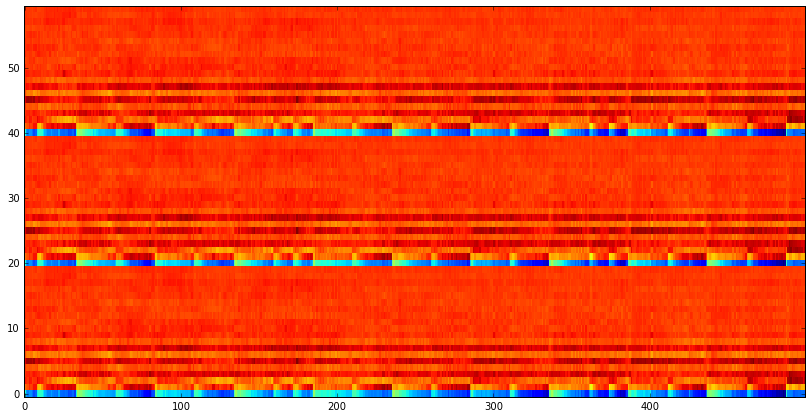

In [23]:

# Transform 1 - Load in audio data, convert to mono
%pylab --no-import-all inline
import scipy, numpy as np, scipy.io.wavfile

audioData = scipy.io.wavfile.read('E:\\projects\\trainingData\\beatSamples.v1\\20160506160348935.wav')
hz = audioData[0]
stereoStream = audioData[1]
# Takes the given audio stream and downconverts it into a single-channel
# mono source normalized between [-1..1] (approximately)
monoStream = np.sum(stereoStream, 1)
monoStream = np.divide(monoStream, 2)

# Transform 2 - Actually take the MFCC with our three defined window sizes

from features import mfcc
from features import logfbank

mfccFeatures_0 = mfcc(
    monoStream, 
    samplerate=hz,
    winlen=0.0232,
    winstep=0.01,
    numcep=20,
    nfilt=20,
    nfft=512,
    lowfreq=0,
    highfreq=hz/2,
    preemph=0.97,
    ceplifter=0,
    appendEnergy=False,
)

mfccFeatures_1 = mfcc(
    monoStream, 
    samplerate=hz,
    winlen=0.0464,
    winstep=0.01,
    numcep=20,
    nfilt=20,
    nfft=512,
    lowfreq=0,
    highfreq=hz/2,
    preemph=0.97,
    ceplifter=0,
    appendEnergy=False,
)

mfccFeatures_2 = mfcc(
    monoStream, 
    samplerate=hz,
    winlen=0.0928,
    winstep=0.01,
    numcep=20,
    nfilt=20,
    nfft=512,
    lowfreq=0,
    highfreq=hz/2,
    preemph=0.97,
    ceplifter=0,
    appendEnergy=False,
)

boundedLen = min(mfccFeatures_0.shape[0], mfccFeatures_1.shape[0], mfccFeatures_2.shape[0])
mfccFeatures_0 = np.resize(mfccFeatures_0, (boundedLen, mfccFeatures_0.shape[1]))
mfccFeatures_1 = np.resize(mfccFeatures_1, (boundedLen, mfccFeatures_1.shape[1]))
mfccFeatures_2 = np.resize(mfccFeatures_2, (boundedLen, mfccFeatures_2.shape[1]))


mfccFeatures = np.concatenate((mfccFeatures_0, mfccFeatures_1, mfccFeatures_2), axis=1)
# N rows of 20 features..
print mfccFeatures.shape

# Note that because our window step is 10ms, we're operating at 100fps.
plt.figure().set_size_inches(14, 7)
plt.imshow(np.transpose(mfccFeatures[0:500, :]), origin='lower', aspect='auto',
             interpolation='nearest')

Alright, this looks promising. The spectrograph does seem to be segmented into around four chunks every second. That's almost exactly what we'd expect. We're going to forgore all the stuff from the paper that involved calculating a sliding median and taking the delta w.r.t it. Again, more training data and the network itself should be able to learn these things.

### Step Two - Training Network